In [6]:
from constants import *
from dataman import mk_cls_dataset, make_run_args_ann, make_run_args_nengo
from augman import dat_shuffle, add_rand_noise, dat_repshuf, pre_arggen_repeat, aug
from run_utils import run_van, run_fancy_van, save_results, make_noisy_arg, run_rc

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

n_classes = 5
dup_num = 10
noise_kw_args = {"scale": 0.005, "sig": False}
cls_type = "disc_spec"

In [74]:
def make_run_args_ann(n_dat, n_cor):
    """change Nengo inputs to the Lasagne input

    output format for dat = [time_steps, dimensions]
    output format for cor = [time_steps, 1, n_classes]"""

    dims = n_dat.shape[1]
    t_with_pause = n_dat.shape[2]

    dim_last = n_dat.reshape((-1, t_with_pause, dims))
    final_dat = dim_last.reshape((-1, 1, dims))

    pause_size = int(PAUSE / dt)
    tot_sigs = n_cor.shape[0]
    n_classes = n_cor.shape[1]
    t_steps = t_with_pause - pause_size

    zer = np.zeros((tot_sigs, pause_size, n_classes), dtype=np.int8)
    re_zer = np.repeat(n_cor, t_steps, axis=0).reshape((tot_sigs, -1, n_classes))
    final_cor = np.concatenate((zer, re_zer), axis=1).reshape(-1, 1, n_classes)

    assert final_cor.shape[0] == final_dat.shape[0]
    ann_cor_idx = np.argmax(final_cor[pause_size+1::510].squeeze(), axis=1)
    assert np.all(ann_cor_idx == np.argmax(n_cor, axis=1))

    return final_dat, final_cor

In [76]:
mk_res = mk_cls_dataset(t_len=0.5, dims=1, n_classes=n_classes,
                        freq=20, class_type=cls_type, save_dir=None)
desc = mk_res[1]
dat = np.array(mk_res[0])

make_basic_arg = make_noisy_arg(dat, desc, add_rand_noise, noise_kw_args=noise_kw_args)

b_dat, b_cor, test_arg = make_basic_arg()

# test data
b_shuf_dat = dat_shuffle(*test_arg)
b_t_dat, b_t_cor = make_run_args_ann(*b_shuf_dat)

# shuffle only, as a baseline for comparison
b_rep_dat, b_rep_cor = dat_repshuf(b_dat, b_cor, reps=dup_num)
b_ann_dat, b_ann_cor = make_run_args_ann(b_rep_dat, b_rep_cor)

# shuffle with noise
rep_noisy = aug(pre_arggen_repeat(dat, dup_num), desc, dup_num,
                add_rand_noise, kwargs=noise_kw_args)
rep_dat, rep_cor = make_run_args_nengo(np.array(rep_noisy))
nengo_dat, nengo_cor = dat_shuffle(rep_dat, rep_cor)

ann_dat, ann_cor = make_run_args_ann(nengo_dat, nengo_cor)

(25500, 1, 1)
(50, 1, 510)


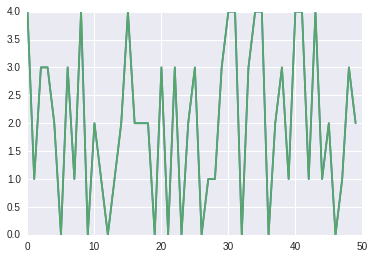

In [91]:
plt.plot(np.argmax(ann_cor[11::510].squeeze(), axis=1))
plt.plot(np.argmax(nengo_cor, axis=1))
print(ann_dat.shape)
print(nengo_dat.shape)

True

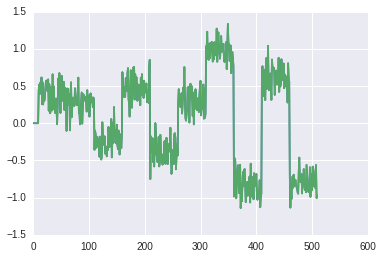

In [96]:
plt.plot(ann_dat[0:510].squeeze())
plt.plot(nengo_dat[0].squeeze())
np.allclose(ann_dat[0:510].squeeze(), nengo_dat[0].squeeze())

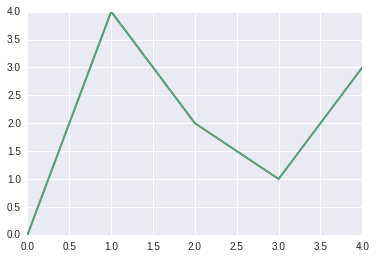

In [80]:
plt.plot(np.argmax(b_t_cor[11::510].squeeze(), axis=1))
plt.plot(np.argmax(b_shuf_dat[1].squeeze(), axis=1))

Check that test and train indexes match up. Which they do.

In [9]:
print(b_t_dat.shape)
print(b_t_cor.shape)

(2550, 1, 1)
(2550, 1, 5)


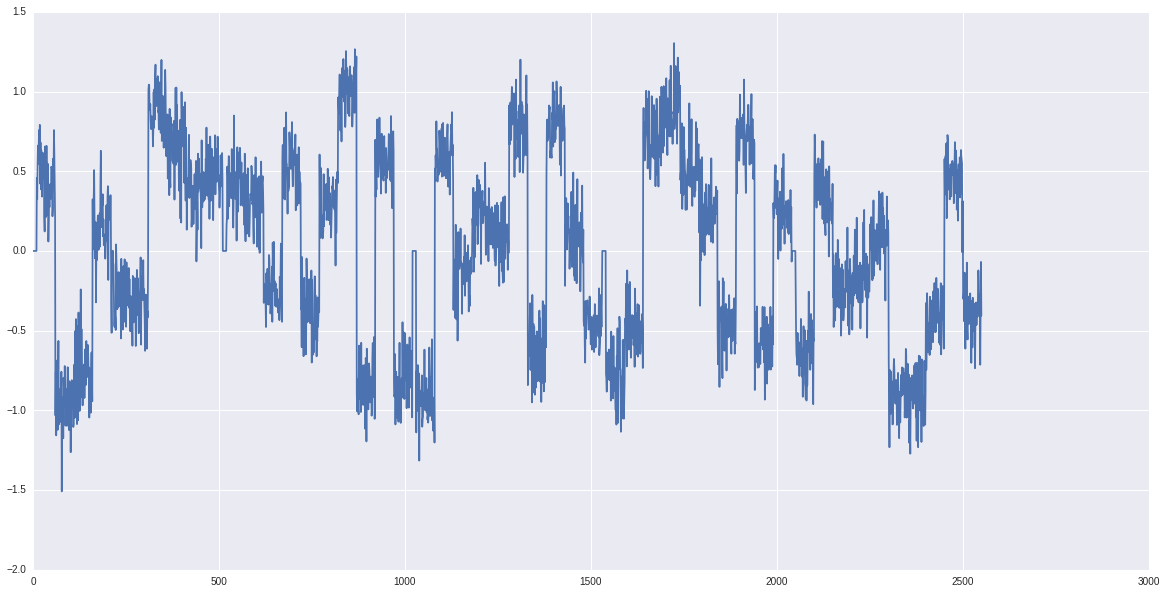

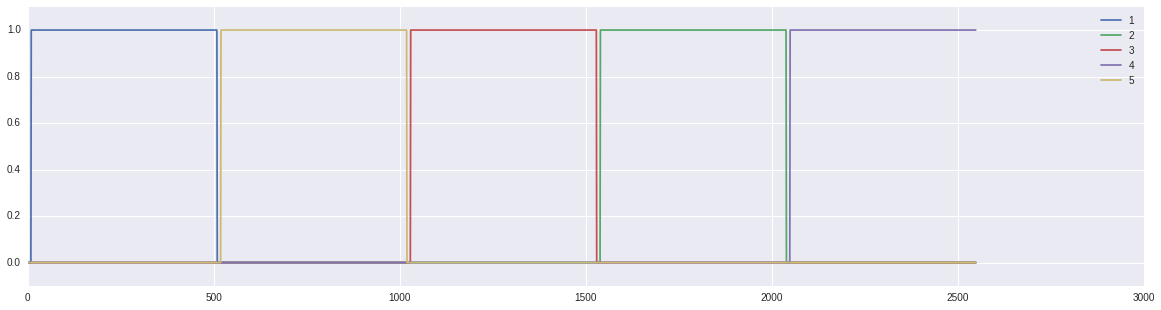

In [81]:
plt.figure(figsize=(20,10))
plt.plot(b_t_dat.squeeze())
plt.figure(figsize=(20,5))
plt.plot(b_t_cor.squeeze())
plt.ylim(-0.1, 1.1)
plt.legend(["1", "2", "3", "4", "5"])

(-0.1, 1.1)

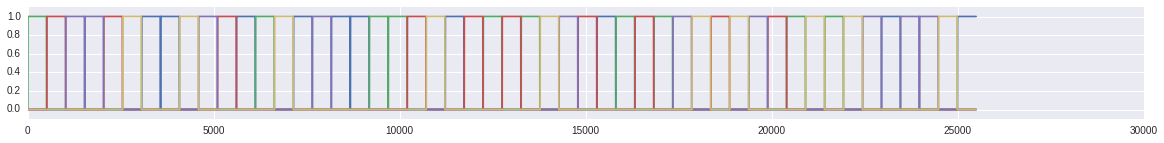

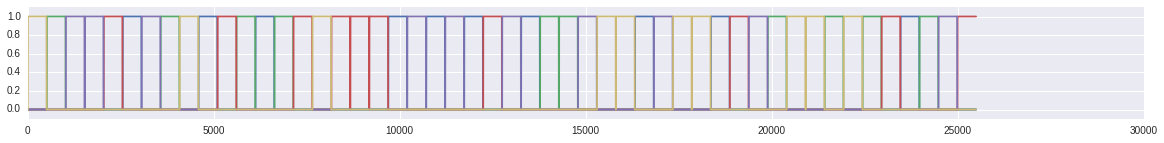

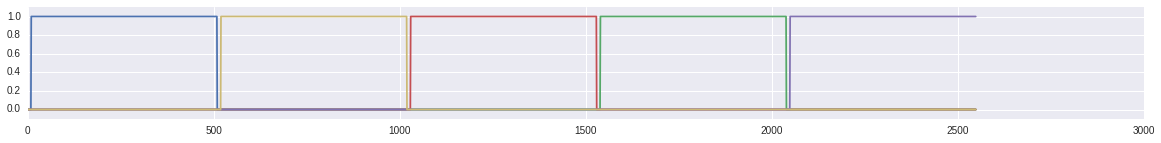

In [85]:
plt.figure(figsize=(20,2))
plt.plot(b_ann_cor.squeeze())
plt.ylim(-0.1, 1.1)

plt.figure(figsize=(20,2))
plt.plot(ann_cor.squeeze())
plt.ylim(-0.1, 1.1)

plt.figure(figsize=(20,2))
plt.plot(b_t_cor.squeeze())
plt.ylim(-0.1, 1.1)

(-0.1, 1.1)

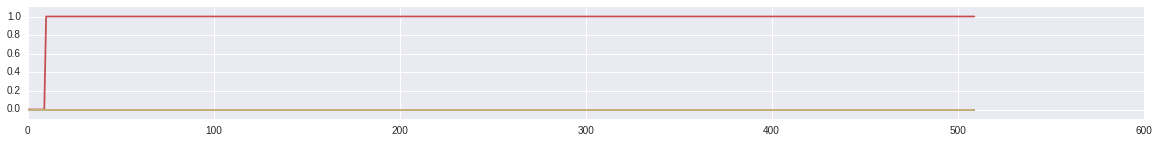

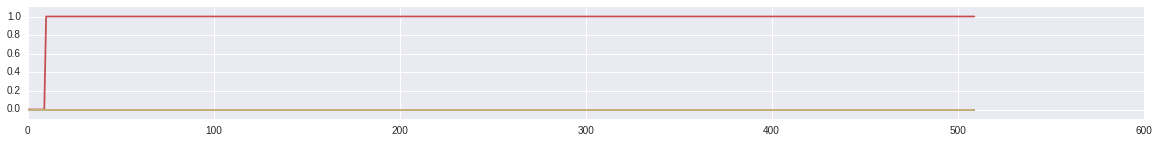

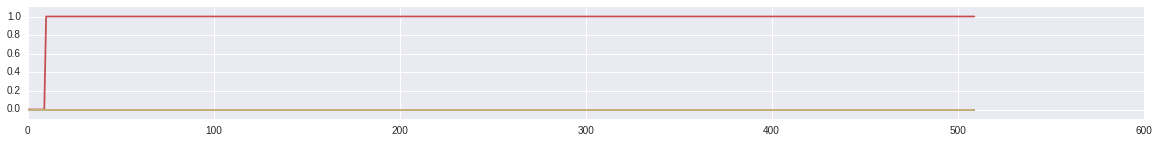

In [88]:
win = 510
plt.figure(figsize=(20,2))
plt.plot(b_ann_cor.squeeze()[win:2*win])
plt.ylim(-0.1, 1.1)

plt.figure(figsize=(20,2))
plt.plot(ann_cor.squeeze()[4*win:5*win])
plt.ylim(-0.1, 1.1)

plt.figure(figsize=(20,2))
plt.plot(b_t_cor.squeeze()[2*win:3*win])
plt.ylim(-0.1, 1.1)

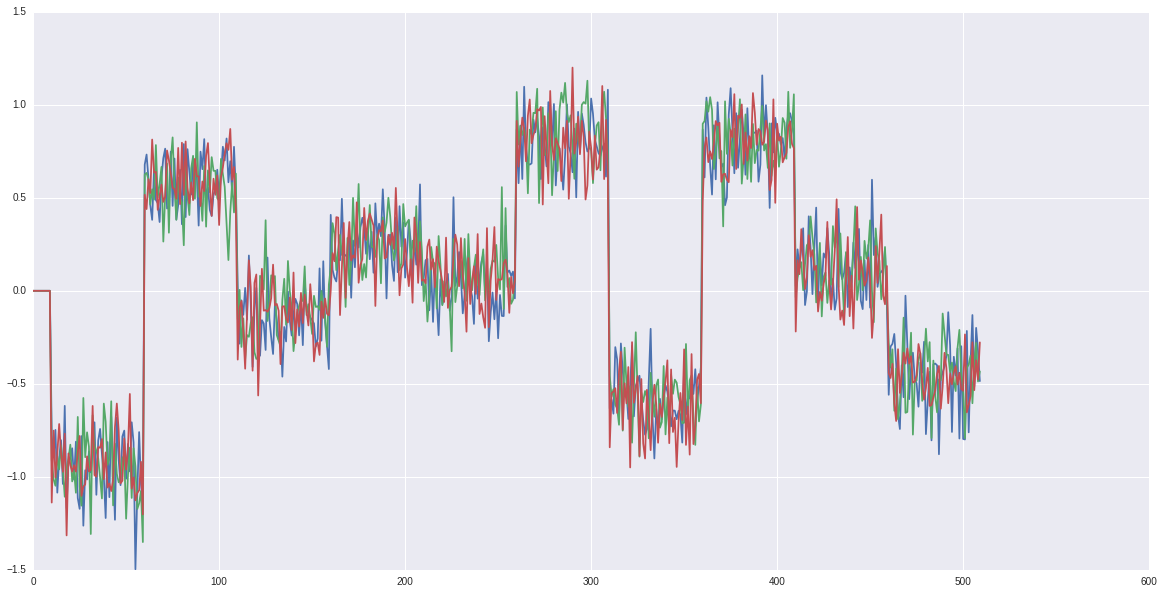

In [89]:
plt.figure(figsize=(20,10))
plt.plot(b_ann_dat.squeeze()[win:2*win])
plt.plot(ann_dat.squeeze()[4*win:5*win])
plt.plot(b_t_dat.squeeze()[2*win:3*win])

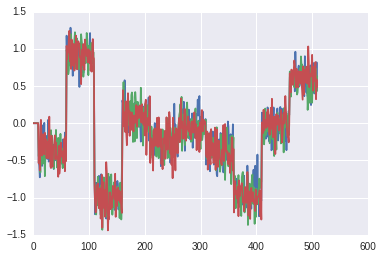

In [28]:
plt.plot(b_shuf_dat[0][4].squeeze())
plt.plot(b_ann_dat.squeeze()[:510])
plt.plot(ann_dat.squeeze()[:510])

So they all still match up when coming out of the shuffle, so it must be when they make the arg that's the problem.